In [91]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [92]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [0]:
np.random.seed(0)

In [0]:
#Train Data
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
#Validation data
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f) 
  

In [96]:
print(type(train_data))
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val =  val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [97]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels"
assert(X_train.shape[1:] == (32, 32, 3)), "The dim of the images is not 32 x 32 x 3"
assert(X_val.shape[1:] == (32, 32, 3)), "The dim of the images is not 32 x 32 x 3"
assert(X_test.shape[1:] == (32, 32, 3)), "The dim of the images is not 32 x 32 x 3"


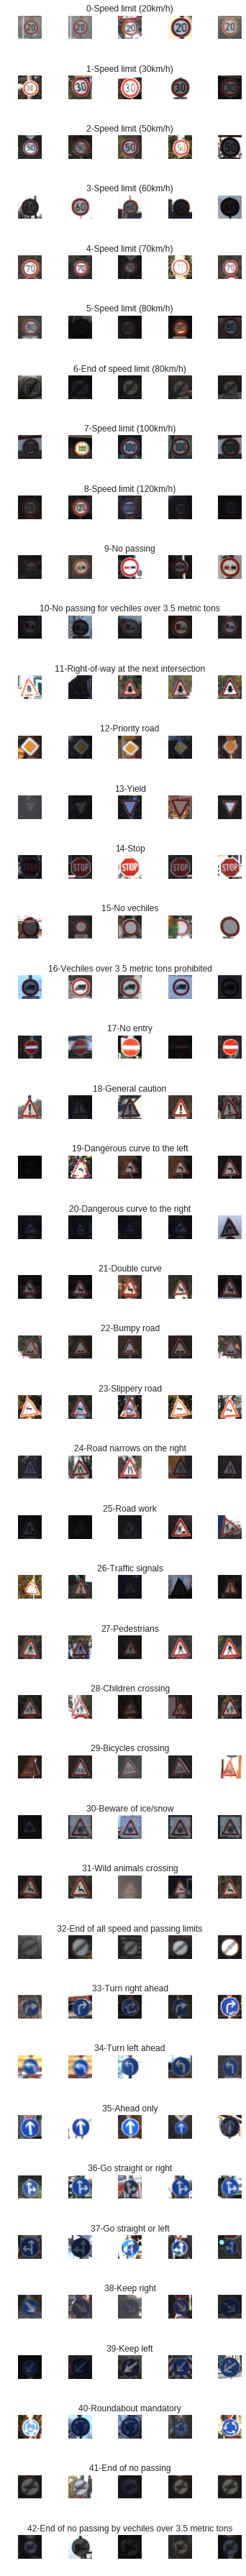

In [99]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples = []

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols = cols, figsize=(5, 50))
fig.tight_layout()
for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0, len(x_selected) - 1), :, :], cmap=plt.get_cmap("gray"))
        axs[j][i].axis("off")
        if i == 2:
            axs[j][i].set_title(str(j) + "-" + row["SignName"])
            num_of_samples.append(len(x_selected))
    #(index / Series)

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


Text(0, 0.5, 'Number of images')

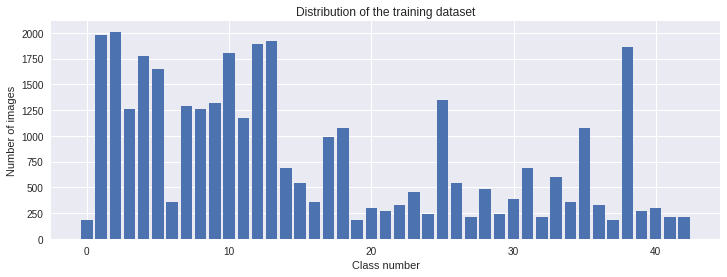

In [100]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

(32, 32, 3)
31


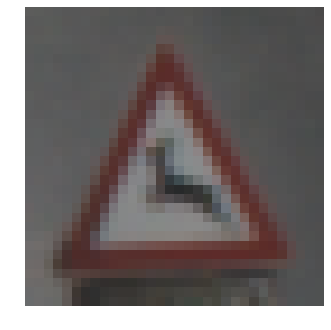

In [101]:
import cv2 


plt.imshow(X_train[560])
plt.axis('off')
print(X_train[560].shape)
print(y_train[560])

(32, 32)


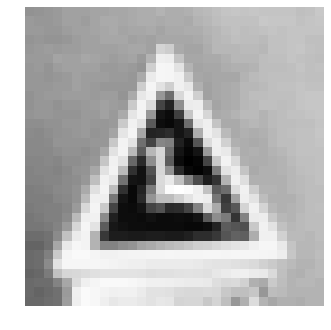

In [102]:
#Converts rgb image to greyscale image 3d to 2d
def grayscale(img):
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  return img

img = grayscale(X_train[560])
plt.imshow(img)
plt.axis("off")
print(img.shape) #We will see our image now 2d.

(32, 32)


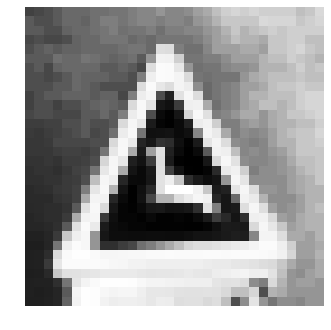

In [103]:
def equalize(img):
  img = cv2.equalizeHist(img) #only accept greyscale img
  return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [0]:
def preprocessing(img):
  img = grayscale(img)
  img = equalize(img)
  img = img / 255
  return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


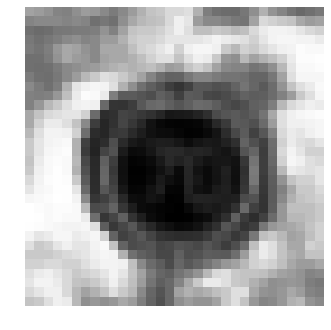

In [105]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [0]:
X_train = X_train.reshape(34799, 32, 32, 1) #reshape the input format
X_val = X_val.reshape(4410, 32, 32, 1) #reshape the input format
X_test = X_test.reshape(12630, 32, 32, 1) #reshape the input format

In [107]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [0]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [0]:
def modified_model():
  model = Sequential()
  #5x5 filter uygula feature map sayısı 30 tane olsun
  model.add(Conv2D(filters=60, kernel_size=(5, 5), input_shape=(32, 32, 1),
                  activation='relu')) #28*28*30
  model.add(Conv2D(filters=60, kernel_size=(5, 5),
                  activation='relu')) #28*28*30
  #reduce parameters and helps overfitting
  model.add(MaxPooling2D(pool_size=(2,2))) #14*14*30
  
  model.add(Conv2D(30, (3, 3), activation='relu')) #12*12*15
  model.add(Conv2D(30, (3, 3), activation='relu')) #12*12*15
  model.add(MaxPooling2D(pool_size=(2, 2))) #6*6*15
  model.add(Dropout(rate = 0.5))
  
  model.add(Flatten()) #Takes Convoluted data and flatten it to 1d format
  model.add(Dense(units = 500, activation='relu'))
  model.add(Dropout(rate = 0.5))
  model.add(Dense(num_classes, activation = 'softmax'))
  #Compile model
  model.compile(Adam(lr = 0.001), loss = 'categorical_crossentropy',
               metrics = ['accuracy'])
  return model

In [116]:
model = modified_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 28, 28, 60)        1560      
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 24, 24, 60)        90060     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 12, 12, 60)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 10, 10, 30)        16230     
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 8, 8, 30)          8130      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 4, 4, 30)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 4, 4, 30)          0         
__________

In [117]:
history = model.fit(X_train, y_train, epochs=10, 
         validation_data = (X_val, y_val),
         batch_size=400, verbose=1, shuffle=1)

Train on 34799 samples, validate on 4410 samples
Epoch 1/10
34799/34799 [==============================] - 6s 162us/step - loss: 2.3595 - acc: 0.3611 - val_loss: 0.7090 - val_acc: 0.8098
Epoch 2/10
34799/34799 [==============================] - 5s 141us/step - loss: 0.6943 - acc: 0.7865 - val_loss: 0.3077 - val_acc: 0.9098
Epoch 3/10
34799/34799 [==============================] - 5s 140us/step - loss: 0.4063 - acc: 0.8742 - val_loss: 0.2193 - val_acc: 0.9361
Epoch 4/10
34799/34799 [==============================] - 5s 139us/step - loss: 0.2860 - acc: 0.9115 - val_loss: 0.1642 - val_acc: 0.9535
Epoch 5/10
34799/34799 [==============================] - 5s 139us/step - loss: 0.2354 - acc: 0.9255 - val_loss: 0.1419 - val_acc: 0.9576
Epoch 6/10
34799/34799 [==============================] - 5s 139us/step - loss: 0.1970 - acc: 0.9378 - val_loss: 0.1102 - val_acc: 0.9689
Epoch 7/10
34799/34799 [==============================] - 5s 139us/step - loss: 0.1570 - acc: 0.9511 - val_loss: 0.1073 - v

Text(0.5, 0, 'epoch')

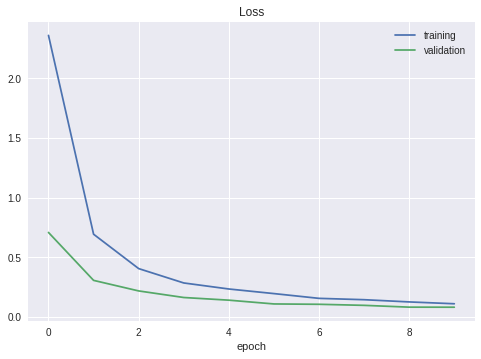

In [118]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

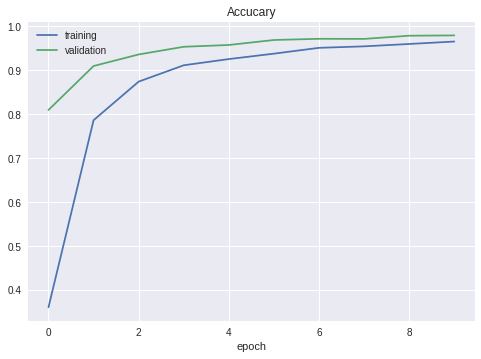

In [119]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['training', 'validation'])
plt.title('Accucary')
plt.xlabel('epoch')

In [120]:
score = model.evaluate(X_test,y_test, verbose=0)
print('Test score:', score[0])
print('Test Accuracy:', score[1])

Test score: 0.15476694424486973
Test Accuracy: 0.960253365022836
